## Zadanie 1

Proszę pobrać zbiór fasion MNIST (torchvision.datasets.FashionMNIST) i zaproponować sieć konwolucyjną do jego klasyfikacji. Dla co najmniej trzech architektur proszę wypisać macierz pomyłek i wykresy funkcji strat podczas uczenia. Proszę spróbować w każdym wypadku podać przynajmniej jeden źle zaklasyfikowany obrazek.

In [1]:
import torch
import torch.nn as nn  # conv layers
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
print(f"Device: {device}")

cpu = torch.device("cpu")

transform = transforms.Compose(
    [transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))]
)

train_dataset = datasets.FashionMNIST(
    root="./data", train=True, download=True, transform=transform
)
test_dataset = datasets.FashionMNIST(
    root="./data", train=False, download=True, transform=transform
)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=1000)

Device: mps


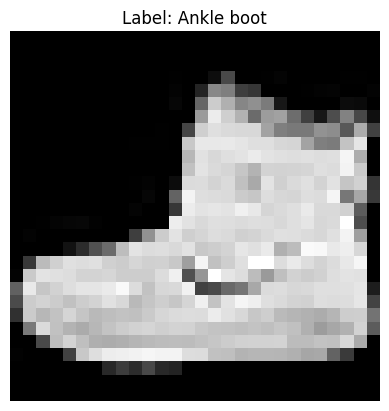

In [2]:
import matplotlib.pyplot as plt

class_names = train_dataset.classes
image, label = train_dataset[0]

plt.imshow(image.squeeze(), cmap="gray")
plt.title(f"Label: {class_names[label]}")
plt.axis("off")
plt.show()

In [3]:
class CNN1(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv = nn.Conv2d(1, 8, 3)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc = nn.Linear(8 * 13 * 13, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv(x)))
        x = torch.flatten(x, 1)
        return self.fc(x)


class CNN2(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 16, 3)
        self.conv2 = nn.Conv2d(16, 32, 3)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc = nn.Linear(32 * 5 * 5, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1)
        return self.fc(x)


class CNN3(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 32, 3)
        self.conv2 = nn.Conv2d(32, 64, 3)
        self.pool = nn.MaxPool2d(2, 2)
        self.dropout = nn.Dropout(0.25)
        self.fc1 = nn.Linear(64 * 5 * 5, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1)
        x = self.dropout(F.relu(self.fc1(x)))
        # dropout between the 1st and 2nd (last) fc layers
        return self.fc2(x)

In [4]:
import numpy as np
import time


def train_model(model, device, epochs=5):
    model.to(device)
    optimizer = torch.optim.Adam(model.parameters())
    criterion = nn.CrossEntropyLoss()
    losses = []

    start = time.time()

    for epoch in range(epochs):
        model.train()  # set training mode
        running_loss = 0.0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()

            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        avg_loss = running_loss / len(train_loader)
        losses.append(avg_loss)

        end = time.time()
        print(
            f"Epoch {epoch + 1}, loss: {avg_loss:.4f}, elapsed: {(end - start):.4} (sec)"
        )

    return losses


def evaluate_model(model, device):
    model.eval()  # set test mode

    y_true, y_pred = [], []
    with torch.no_grad():
        for images, labels in test_loader:
            images = images.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(preds.cpu().numpy())

    return np.array(y_true), np.array(y_pred)

In [5]:
import random
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
from torchinfo import summary


def run_and_report(model_class, name, device=device, epochs=5):
    print(f"\n=== {name} ===")
    model = model_class()
    losses = train_model(model, device, epochs)

    # loss plot
    plt.plot(losses)
    plt.title(f"{name} - loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.grid()
    plt.show()

    # eval
    y_true, y_pred = evaluate_model(model, device)
    cm = confusion_matrix(y_true, y_pred)

    sns.heatmap(
        cm,
        annot=True,
        fmt="d",
        cmap="Blues",
        xticklabels=class_names,
        yticklabels=class_names,
    )
    plt.title(f"{name} - CM")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.show()

    print("Metrics:")
    print(classification_report(y_true, y_pred, target_names=class_names, digits=4))

    print(summary(model, input_size=(1, 1, 28, 28), device=device))

    # choose an example of a wrongly classified clothing
    wrong_idx = np.where(y_true != y_pred)[0]
    if len(wrong_idx) > 0:
        idx = random.choice(wrong_idx)
        img = test_dataset[idx][0].squeeze()
        plt.imshow(img, cmap="gray")
        plt.title(
            f"Predicted: {class_names[y_pred[idx]]}, True: {class_names[y_true[idx]]}"
        )
        plt.show()


=== CNN 1 ===
Epoch 1, loss: 0.4996, elapsed: 3.618 (sec)
Epoch 2, loss: 0.3491, elapsed: 7.06 (sec)
Epoch 3, loss: 0.3200, elapsed: 10.5 (sec)
Epoch 4, loss: 0.3004, elapsed: 13.87 (sec)
Epoch 5, loss: 0.2875, elapsed: 17.25 (sec)


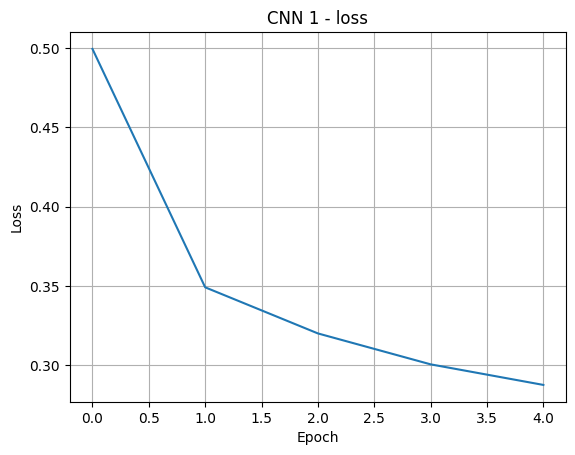

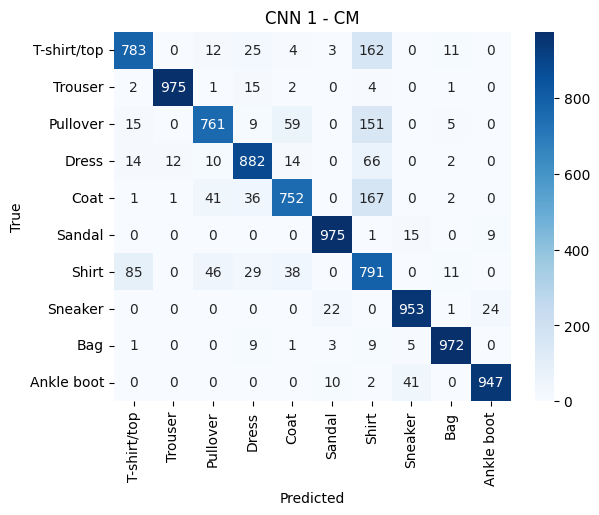

Metrics:
              precision    recall  f1-score   support

 T-shirt/top     0.8690    0.7830    0.8238      1000
     Trouser     0.9868    0.9750    0.9809      1000
    Pullover     0.8737    0.7610    0.8135      1000
       Dress     0.8776    0.8820    0.8798      1000
        Coat     0.8644    0.7520    0.8043      1000
      Sandal     0.9625    0.9750    0.9687      1000
       Shirt     0.5846    0.7910    0.6723      1000
     Sneaker     0.9398    0.9530    0.9464      1000
         Bag     0.9672    0.9720    0.9696      1000
  Ankle boot     0.9663    0.9470    0.9566      1000

    accuracy                         0.8791     10000
   macro avg     0.8892    0.8791    0.8816     10000
weighted avg     0.8892    0.8791    0.8816     10000

Layer (type:depth-idx)                   Output Shape              Param #
CNN1                                     [1, 10]                   --
├─Conv2d: 1-1                            [1, 8, 26, 26]            80
├─MaxPool2d: 1-2 

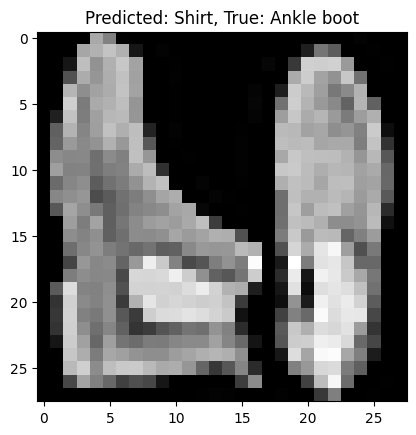


=== CNN 2 ===
Epoch 1, loss: 0.5297, elapsed: 5.285 (sec)
Epoch 2, loss: 0.3620, elapsed: 10.46 (sec)
Epoch 3, loss: 0.3212, elapsed: 15.63 (sec)
Epoch 4, loss: 0.2942, elapsed: 20.8 (sec)
Epoch 5, loss: 0.2775, elapsed: 25.96 (sec)


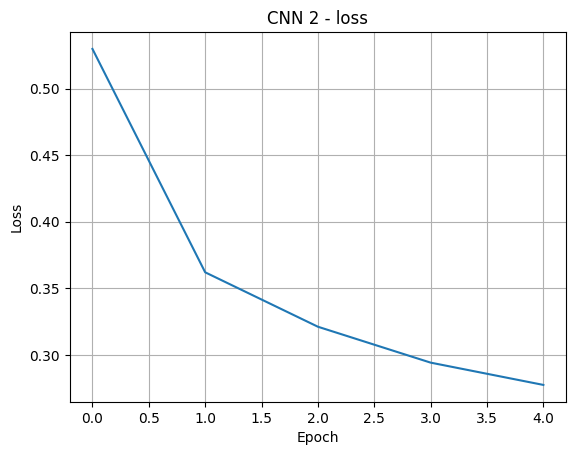

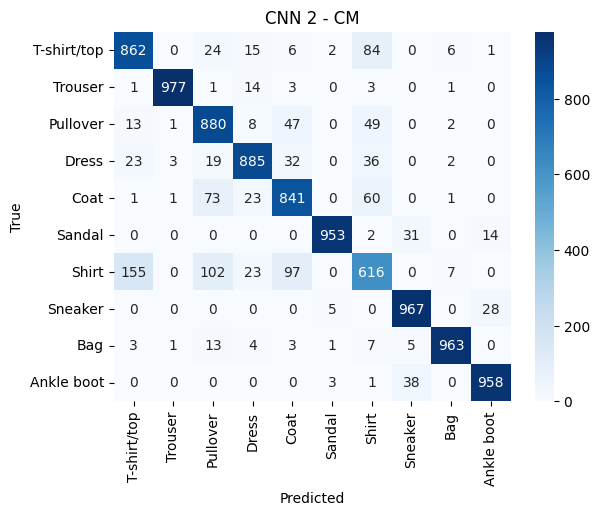

Metrics:
              precision    recall  f1-score   support

 T-shirt/top     0.8147    0.8620    0.8377      1000
     Trouser     0.9939    0.9770    0.9854      1000
    Pullover     0.7914    0.8800    0.8333      1000
       Dress     0.9105    0.8850    0.8976      1000
        Coat     0.8173    0.8410    0.8290      1000
      Sandal     0.9886    0.9530    0.9705      1000
       Shirt     0.7179    0.6160    0.6631      1000
     Sneaker     0.9289    0.9670    0.9476      1000
         Bag     0.9807    0.9630    0.9717      1000
  Ankle boot     0.9570    0.9580    0.9575      1000

    accuracy                         0.8902     10000
   macro avg     0.8901    0.8902    0.8893     10000
weighted avg     0.8901    0.8902    0.8893     10000

Layer (type:depth-idx)                   Output Shape              Param #
CNN2                                     [1, 10]                   --
├─Conv2d: 1-1                            [1, 16, 26, 26]           160
├─MaxPool2d: 1-2

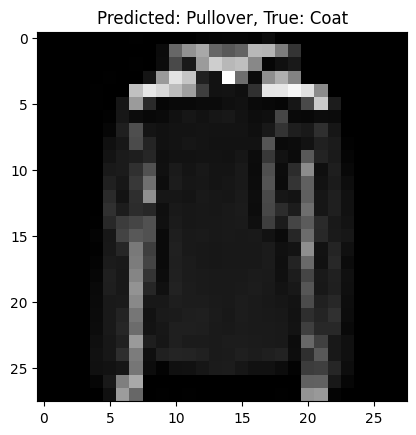


=== CNN 3 ===
Epoch 1, loss: 0.4983, elapsed: 6.628 (sec)
Epoch 2, loss: 0.3296, elapsed: 13.2 (sec)
Epoch 3, loss: 0.2866, elapsed: 19.63 (sec)
Epoch 4, loss: 0.2544, elapsed: 26.09 (sec)
Epoch 5, loss: 0.2305, elapsed: 32.42 (sec)


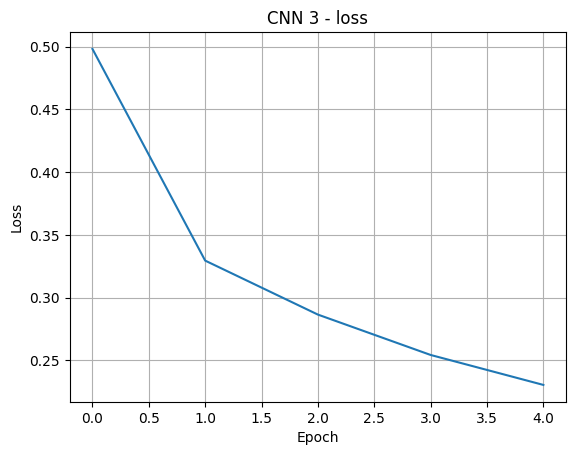

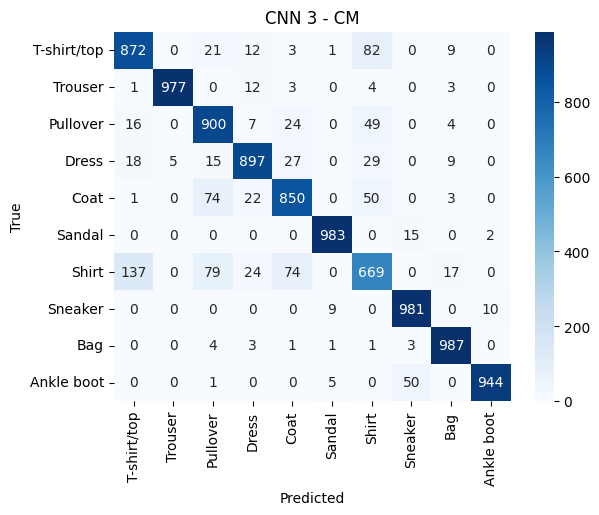

Metrics:
              precision    recall  f1-score   support

 T-shirt/top     0.8344    0.8720    0.8528      1000
     Trouser     0.9949    0.9770    0.9859      1000
    Pullover     0.8227    0.9000    0.8596      1000
       Dress     0.9181    0.8970    0.9074      1000
        Coat     0.8656    0.8500    0.8577      1000
      Sandal     0.9840    0.9830    0.9835      1000
       Shirt     0.7568    0.6690    0.7102      1000
     Sneaker     0.9352    0.9810    0.9575      1000
         Bag     0.9564    0.9870    0.9715      1000
  Ankle boot     0.9874    0.9440    0.9652      1000

    accuracy                         0.9060     10000
   macro avg     0.9056    0.9060    0.9051     10000
weighted avg     0.9056    0.9060    0.9051     10000

Layer (type:depth-idx)                   Output Shape              Param #
CNN3                                     [1, 10]                   --
├─Conv2d: 1-1                            [1, 32, 26, 26]           320
├─MaxPool2d: 1-2

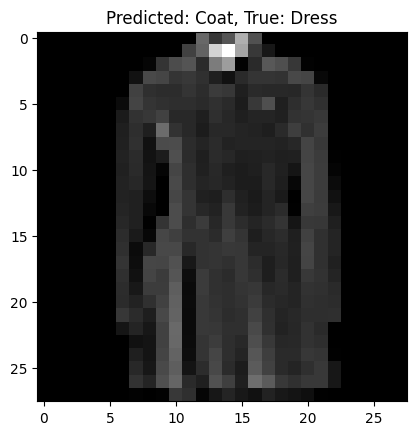

In [6]:
run_and_report(CNN1, "CNN 1")
run_and_report(CNN2, "CNN 2")
run_and_report(CNN3, "CNN 3")

## Zadanie 2

Dla jednej wybranej architektury, proszę porównać czas uczenia sieci na CPU i na GPU, do czego mogą Państwo wykorzystać własną kartę NVidii lub zasoby Colaba. W Runtime->Change Runtime Type musi być zaznaczona opcja "T4 GPU".


=== CNN3 (CPU) ===
Epoch 1, loss: 0.5168, elapsed: 11.65 (sec)
Epoch 2, loss: 0.3366, elapsed: 23.45 (sec)
Epoch 3, loss: 0.2889, elapsed: 35.17 (sec)
Epoch 4, loss: 0.2566, elapsed: 47.87 (sec)
Epoch 5, loss: 0.2335, elapsed: 60.3 (sec)


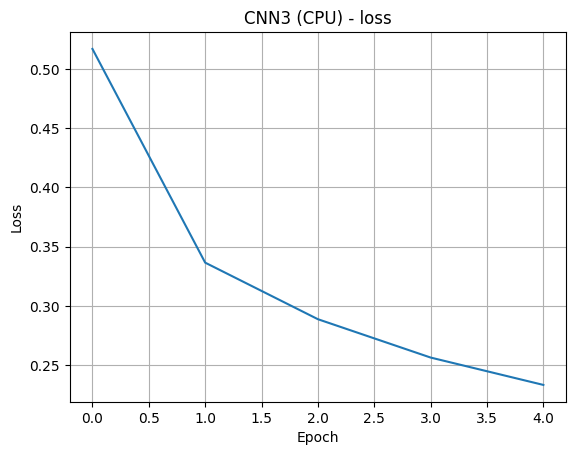

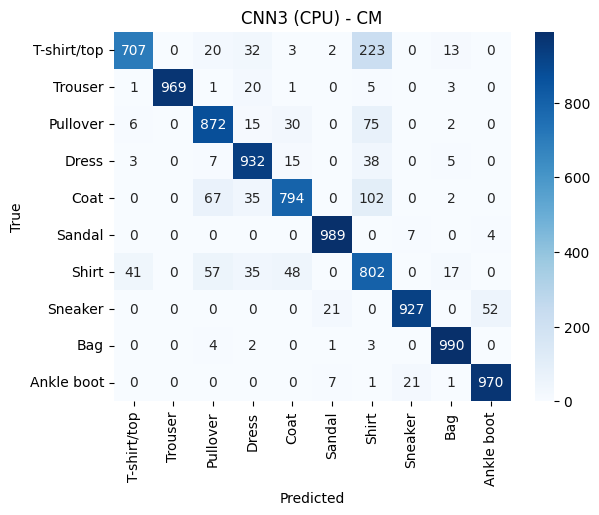

Metrics:
              precision    recall  f1-score   support

 T-shirt/top     0.9327    0.7070    0.8043      1000
     Trouser     1.0000    0.9690    0.9843      1000
    Pullover     0.8482    0.8720    0.8600      1000
       Dress     0.8702    0.9320    0.9000      1000
        Coat     0.8911    0.7940    0.8398      1000
      Sandal     0.9696    0.9890    0.9792      1000
       Shirt     0.6421    0.8020    0.7132      1000
     Sneaker     0.9707    0.9270    0.9483      1000
         Bag     0.9584    0.9900    0.9739      1000
  Ankle boot     0.9454    0.9700    0.9576      1000

    accuracy                         0.8952     10000
   macro avg     0.9029    0.8952    0.8961     10000
weighted avg     0.9029    0.8952    0.8961     10000

Layer (type:depth-idx)                   Output Shape              Param #
CNN3                                     [1, 10]                   --
├─Conv2d: 1-1                            [1, 32, 26, 26]           320
├─MaxPool2d: 1-2

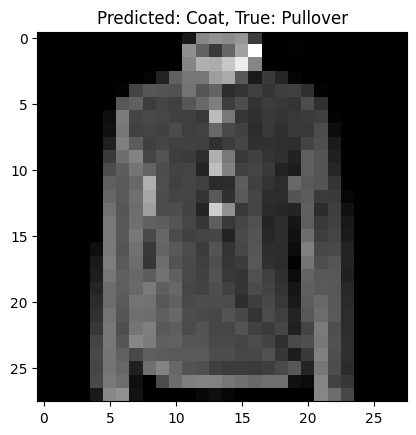

In [7]:
run_and_report(CNN3, "CNN3 (CPU)", cpu)

## Zadanie 3*

Dla zainteresowanych - proszę doczytać o mechanizmie dropoutu (https://pytorch.org/docs/stable/generated/torch.nn.Dropout.html, https://machinelearningmastery.com/dropout-for-regularizing-deep-neural-networks/) i spróbować zastosować mechanizm dropoutu do stworzonej sieci neuronowej.

In [8]:
class DeepCNN(nn.Module):
    def __init__(self, dropout=0.5):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 32, 3)
        self.conv2 = nn.Conv2d(32, 64, 3)
        self.conv3 = nn.Conv2d(64, 128, 3)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(128 * 3 * 3, 512)
        self.dropout = nn.Dropout(dropout)
        self.fc2 = nn.Linear(512, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = F.relu(self.conv3(x))
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        return self.fc2(x)


=== Deep CNN (0.5 dropout) ===
Epoch 1, loss: 0.5208, elapsed: 8.293 (sec)
Epoch 2, loss: 0.3305, elapsed: 16.01 (sec)
Epoch 3, loss: 0.2808, elapsed: 24.04 (sec)
Epoch 4, loss: 0.2518, elapsed: 32.03 (sec)
Epoch 5, loss: 0.2251, elapsed: 39.93 (sec)
Epoch 6, loss: 0.1998, elapsed: 47.69 (sec)
Epoch 7, loss: 0.1824, elapsed: 55.64 (sec)
Epoch 8, loss: 0.1651, elapsed: 63.6 (sec)
Epoch 9, loss: 0.1498, elapsed: 71.38 (sec)
Epoch 10, loss: 0.1357, elapsed: 79.32 (sec)
Epoch 11, loss: 0.1226, elapsed: 87.39 (sec)
Epoch 12, loss: 0.1109, elapsed: 95.14 (sec)
Epoch 13, loss: 0.1029, elapsed: 102.9 (sec)
Epoch 14, loss: 0.0930, elapsed: 110.8 (sec)
Epoch 15, loss: 0.0836, elapsed: 118.7 (sec)
Epoch 16, loss: 0.0779, elapsed: 126.6 (sec)
Epoch 17, loss: 0.0734, elapsed: 134.1 (sec)
Epoch 18, loss: 0.0764, elapsed: 142.2 (sec)
Epoch 19, loss: 0.0667, elapsed: 149.9 (sec)
Epoch 20, loss: 0.0642, elapsed: 157.6 (sec)


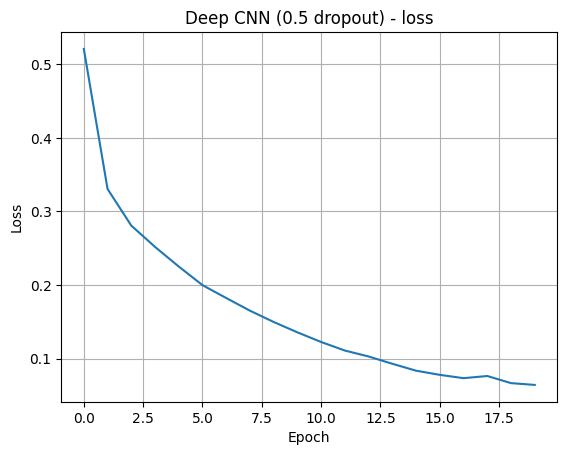

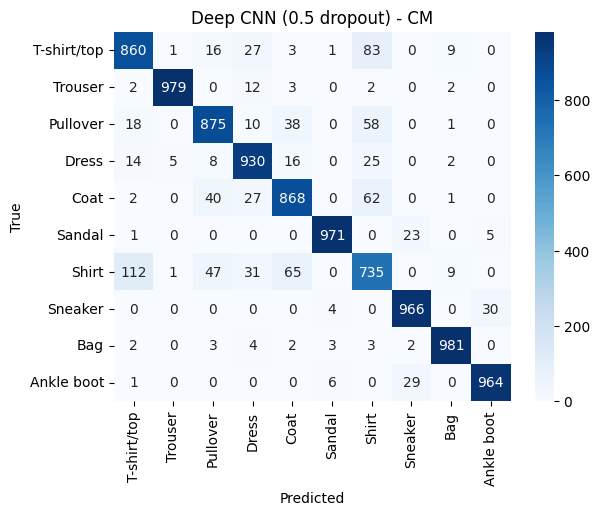

Metrics:
              precision    recall  f1-score   support

 T-shirt/top     0.8498    0.8600    0.8549      1000
     Trouser     0.9929    0.9790    0.9859      1000
    Pullover     0.8847    0.8750    0.8798      1000
       Dress     0.8934    0.9300    0.9113      1000
        Coat     0.8724    0.8680    0.8702      1000
      Sandal     0.9858    0.9710    0.9783      1000
       Shirt     0.7593    0.7350    0.7470      1000
     Sneaker     0.9471    0.9660    0.9564      1000
         Bag     0.9761    0.9810    0.9786      1000
  Ankle boot     0.9650    0.9640    0.9645      1000

    accuracy                         0.9129     10000
   macro avg     0.9126    0.9129    0.9127     10000
weighted avg     0.9126    0.9129    0.9127     10000

Layer (type:depth-idx)                   Output Shape              Param #
DeepCNN                                  [1, 10]                   --
├─Conv2d: 1-1                            [1, 32, 26, 26]           320
├─MaxPool2d: 1-2

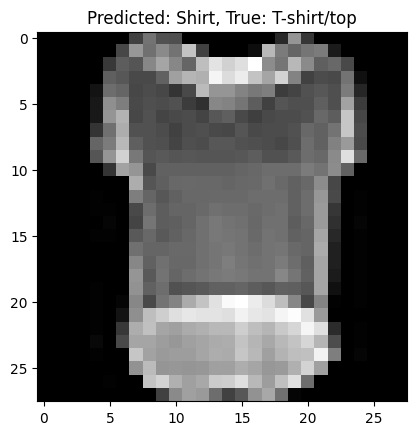


=== Deep CNN (no dropout) ===
Epoch 1, loss: 0.4901, elapsed: 8.011 (sec)
Epoch 2, loss: 0.3084, elapsed: 15.45 (sec)
Epoch 3, loss: 0.2590, elapsed: 22.79 (sec)
Epoch 4, loss: 0.2273, elapsed: 30.48 (sec)
Epoch 5, loss: 0.2018, elapsed: 38.34 (sec)
Epoch 6, loss: 0.1769, elapsed: 46.13 (sec)
Epoch 7, loss: 0.1554, elapsed: 54.06 (sec)
Epoch 8, loss: 0.1363, elapsed: 61.63 (sec)
Epoch 9, loss: 0.1172, elapsed: 69.47 (sec)
Epoch 10, loss: 0.1008, elapsed: 77.14 (sec)
Epoch 11, loss: 0.0883, elapsed: 84.93 (sec)
Epoch 12, loss: 0.0762, elapsed: 92.69 (sec)
Epoch 13, loss: 0.0673, elapsed: 100.5 (sec)
Epoch 14, loss: 0.0575, elapsed: 108.3 (sec)
Epoch 15, loss: 0.0575, elapsed: 116.0 (sec)
Epoch 16, loss: 0.0476, elapsed: 123.6 (sec)
Epoch 17, loss: 0.0475, elapsed: 131.6 (sec)
Epoch 18, loss: 0.0384, elapsed: 139.1 (sec)
Epoch 19, loss: 0.0407, elapsed: 146.7 (sec)
Epoch 20, loss: 0.0371, elapsed: 154.2 (sec)


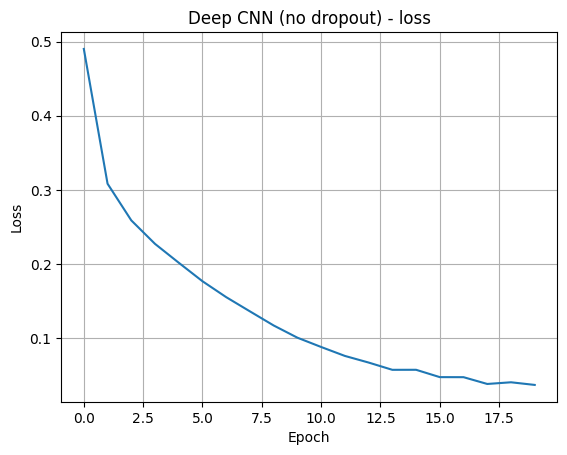

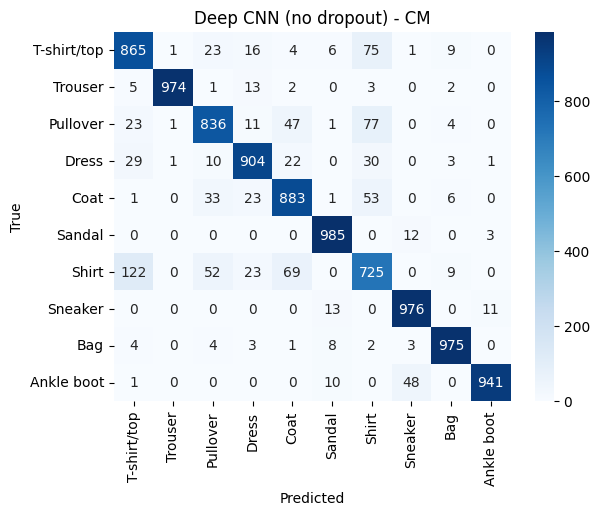

Metrics:
              precision    recall  f1-score   support

 T-shirt/top     0.8238    0.8650    0.8439      1000
     Trouser     0.9969    0.9740    0.9853      1000
    Pullover     0.8717    0.8360    0.8535      1000
       Dress     0.9104    0.9040    0.9072      1000
        Coat     0.8589    0.8830    0.8708      1000
      Sandal     0.9619    0.9850    0.9733      1000
       Shirt     0.7513    0.7250    0.7379      1000
     Sneaker     0.9385    0.9760    0.9569      1000
         Bag     0.9673    0.9750    0.9711      1000
  Ankle boot     0.9843    0.9410    0.9622      1000

    accuracy                         0.9064     10000
   macro avg     0.9065    0.9064    0.9062     10000
weighted avg     0.9065    0.9064    0.9062     10000

Layer (type:depth-idx)                   Output Shape              Param #
DeepCNN                                  [1, 10]                   --
├─Conv2d: 1-1                            [1, 32, 26, 26]           320
├─MaxPool2d: 1-2

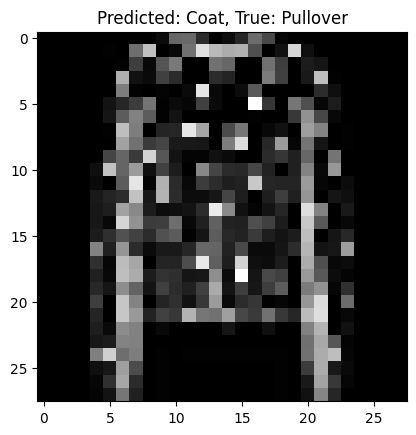

In [9]:
from functools import partial

run_and_report(partial(DeepCNN, 0.5), "Deep CNN (0.5 dropout)", device, 20)
run_and_report(partial(DeepCNN, 0), "Deep CNN (no dropout)", device, 20)